Starting simulation...


Time Steps: 100%|██████████| 100/100 [44:09<00:00, 26.50s/it]

Total runtime: 2649.83 seconds
True traj: [array([1877.68087068, 4755.33407312]), array([1881.82855804, 4757.60781764]), array([1885.44234931, 4760.08579393]), array([1889.24713127, 4762.85471313]), array([1893.25421318, 4765.8017194 ]), array([1897.45801144, 4767.8939278 ]), array([1901.94079003, 4769.34597415]), array([1906.48049077, 4770.40411981]), array([1911.70306762, 4771.18764819]), array([1917.17906682, 4771.52508626]), array([1922.22692784, 4771.43234905]), array([1927.35528344, 4771.30518399]), array([1932.23364895, 4771.45455033]), array([1936.80001442, 4771.80024343]), array([1941.48376393, 4773.07023435]), array([1946.15225648, 4774.66281177]), array([1950.76738088, 4776.53687395]), array([1954.86469885, 4778.13411154]), array([1958.45318808, 4779.75870874]), array([1961.9288195 , 4782.49010535]), array([1964.18482013, 4785.61464852]), array([1966.93462822, 4789.14924419]), array([1970.33502122, 4793.24914848]), array([1973.94088841, 4797.94679837]), array([1978.29124464,

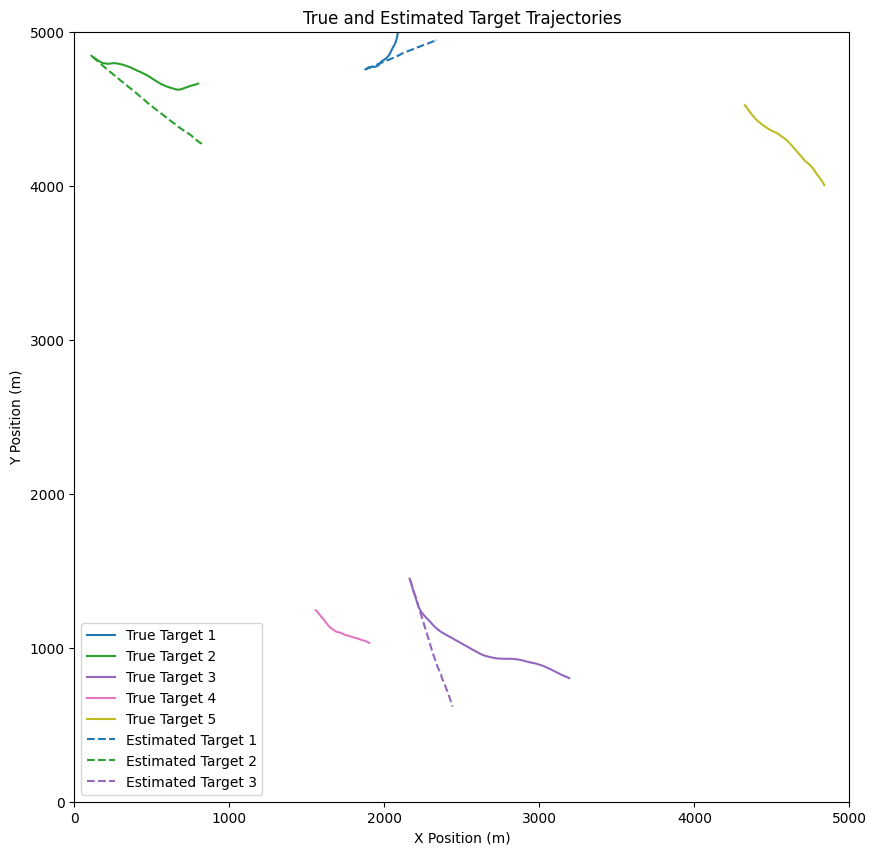

True traj: [array([1877.68087068, 4755.33407312]), array([1881.82855804, 4757.60781764]), array([1885.44234931, 4760.08579393]), array([1889.24713127, 4762.85471313]), array([1893.25421318, 4765.8017194 ]), array([1897.45801144, 4767.8939278 ]), array([1901.94079003, 4769.34597415]), array([1906.48049077, 4770.40411981]), array([1911.70306762, 4771.18764819]), array([1917.17906682, 4771.52508626])]
True traj: [array([ 109.78408589, 4843.92692869]), array([ 116.53648185, 4838.07927305]), array([ 123.24501416, 4833.38145859]), array([ 130.08316289, 4828.8923694 ]), array([ 136.33575942, 4824.07348625]), array([ 143.31864863, 4819.59776274]), array([ 150.08099136, 4815.32936437]), array([ 156.03748226, 4811.39035661]), array([ 161.535642  , 4808.25627311]), array([ 166.79131571, 4804.74069882])]
True traj: [array([2162.53753652, 1448.44113353]), array([2165.83204248, 1439.55422912]), array([2169.48382836, 1430.05065715]), array([2172.47049827, 1420.17245571]), array([2175.41482292, 1409.7

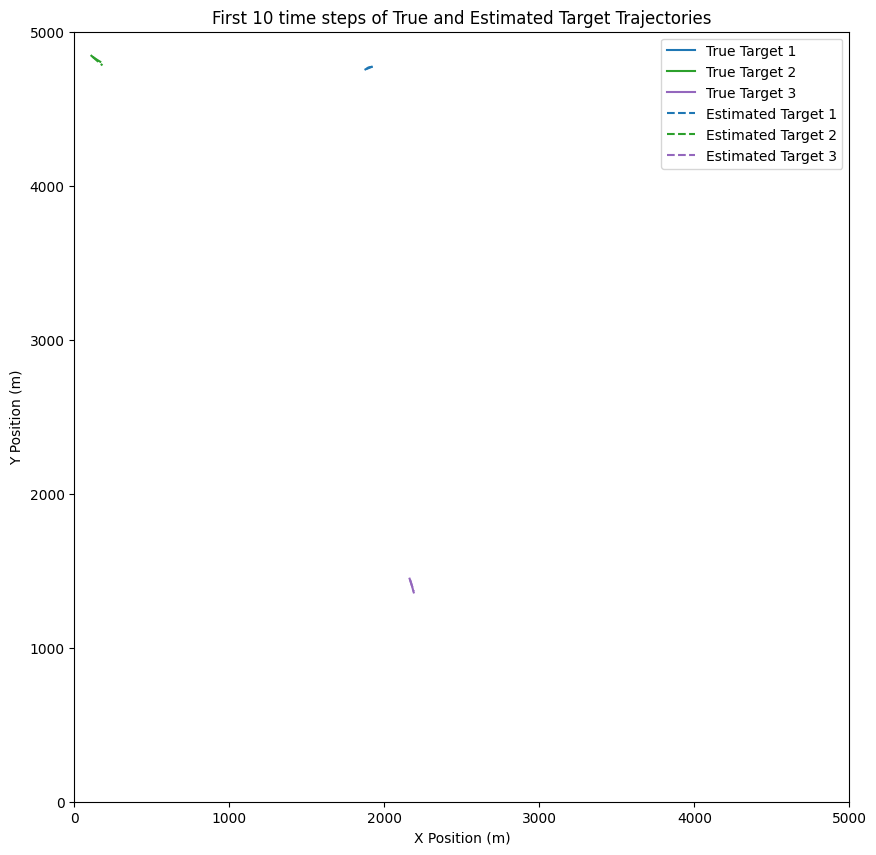

RMSE over all time steps and targets: 242.04 meters


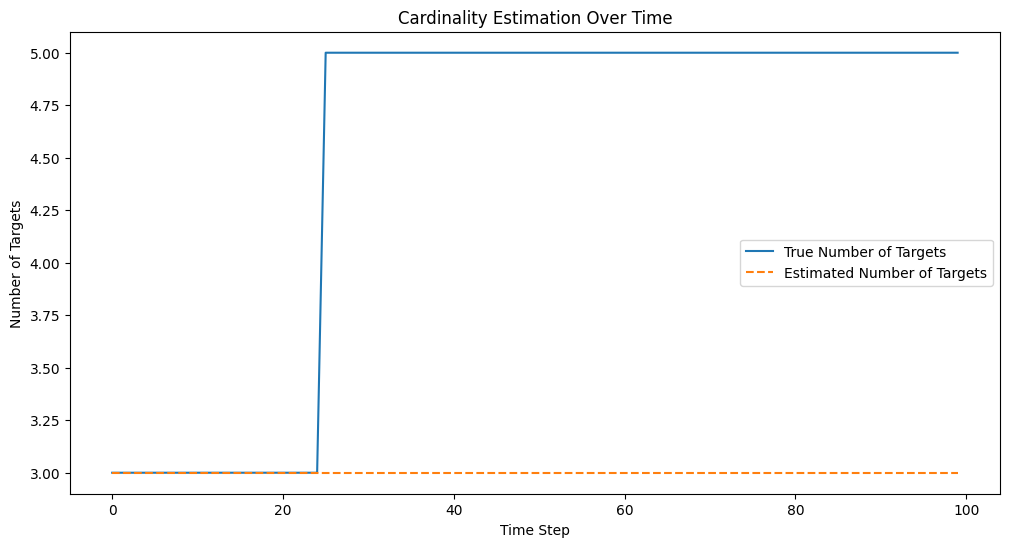

Existence Probability RMSE: 0.55


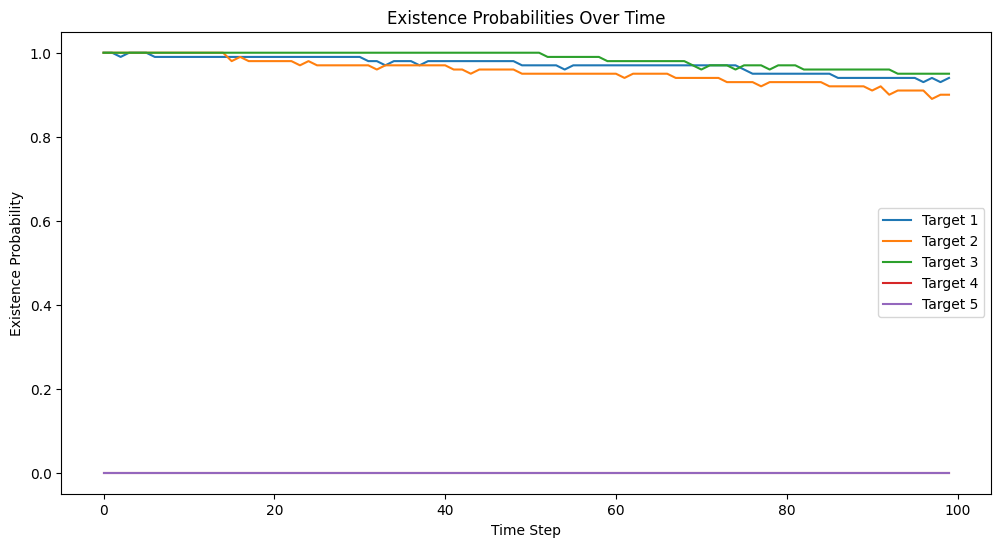

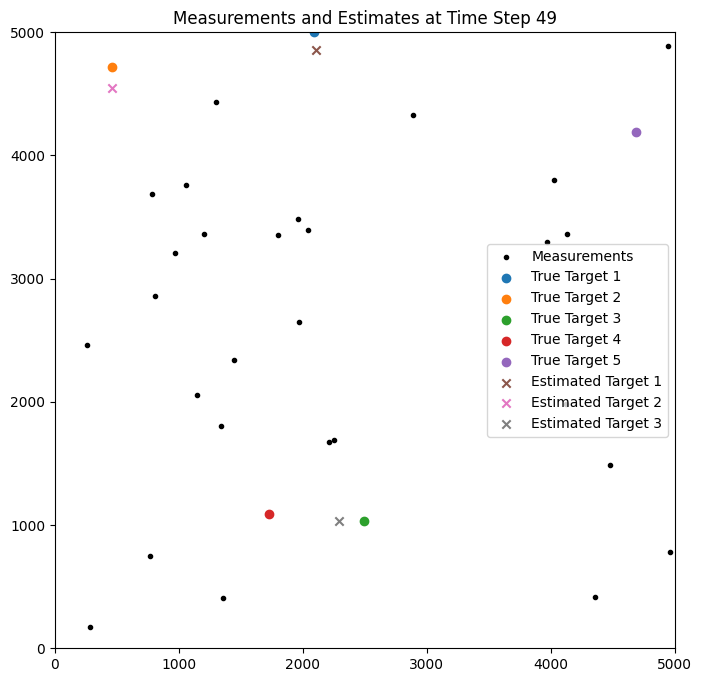

In [1]:
# Import necessary libraries
import numpy as np
from scipy.stats import multivariate_normal, poisson
import math
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # Library for progress bars
from joblib import Parallel, delayed
# Set random seed for reproducibility (optional)
np.random.seed(42)



# Function to initialize target state upon birth
def initialize_target_state():
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # x velocity
        np.random.uniform(-V_max, V_max)   # y velocity
    ])
    return np.concatenate((position, velocity))


estimated_states = []


# =========================
# 1. Simulation Parameters
# =========================

# Surveillance area dimensions
L_x = 5000.0  # Width in meters
L_y = 5000.0  # Height in meters

# Time parameters
T = 100.0               # Total simulation time in seconds

delta_t = 1.0           # Time step in seconds
K = int(T / delta_t)    # Total number of time steps
time_vector = [k * delta_t for k in range(K)]

# Maximum number of potential targets
N_max = 5

# Target birth and death schedule
# Each tuple: (birth_time_step, death_time_step)
target_schedule = [
    (0, K),      # Target 1: born at time step 0, dies at time step K
    (0, K),      # Target 2
    (0, K),      # Target 3
    (25, K),     # Target 4: born at time step 25
    (25, K),     # Target 5: born at time step 25
]

# Motion model parameters
sigma_process = np.sqrt(0.5)  # Standard deviation of the process noise
V_max = 10.0         # Maximum target velocity in m/s

# Sensor model parameters
sigma_measurement = 10.0  # Standard deviation of measurement noise
R = sigma_measurement ** 2 * np.eye(2)  # Measurement noise covariance matrix

Lambda_n = 1  # Average number of measurement received per time step for a target that is alive #ON PEUT SUREMENT LE METTRE EGAL A TAU

# Clutter model parameters
Lambda_C = 20  # Average number of clutter measurements per time step

# Transition probabilities for existence variables
P_S = 0.99  # Probability that an active target survives
P_B = 0.01  # Probability that a new target is born



# Initialize process noise covariance matrix Q
def get_process_noise_covariance(delta_t, sigma_process):
    Q = sigma_process ** 2 * np.array([
        [delta_t ** 3 / 3, 0, delta_t ** 2 / 2, 0],
        [0, delta_t ** 3 / 3, 0, delta_t ** 2 / 2],
        [delta_t ** 2 / 2, 0, delta_t, 0],
        [0, delta_t ** 2 / 2, 0, delta_t]
    ])
    return Q

Q = get_process_noise_covariance(delta_t, sigma_process)

# State transition matrix A
A = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Predefined death state
x_death = np.array([0, 0, 0, 0])

# =========================
# 2. Initialization
# =========================

# Initialize true target states and existence flags
target_states = [np.zeros(4) for _ in range(N_max)]  # State: [x, y, vx, vy]
existence_flags = [0 for _ in range(N_max)]          # Existence flag: 0 (inactive), 1 (active)
target_trajectories = [[] for _ in range(N_max)]     # Store true trajectories
measurements_history = []                            # Store measurements at each time step

# Initialize particles
N_p = 100
particles = []




# Initialize lists to store estimates over time
estimated_trajectories = [[] for _ in range(N_max)]
existence_probs_over_time = [[] for _ in range(N_max)]

# =========================
# 3. Helper Functions
# =========================

# Function to initialize target state upon birth
def initialize_target_state():
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # x velocity
        np.random.uniform(-V_max, V_max)   # y velocity
    ])
    return np.concatenate((position, velocity))

# Function to update true targets
def update_true_targets(k, target_states, existence_flags, target_schedule):  #this functions returns nothing, could be problematic
    for n in range(N_max):
        birth_time, death_time = target_schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # Target is born, initialize state
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move target using motion model
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Ensure target stays within surveillance area
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0

# Function to generate clutter measurements
def generate_clutter_measurements(): #ok pour cette fonction
    num_clutter = np.random.poisson(Lambda_C)
    clutter_measurements = np.random.uniform(
        [0, 0],
        [L_x, L_y],
        size=(num_clutter, 2)
    )
    return clutter_measurements

# Function to generate measurements
def generate_measurements(target_states, existence_flags):
    measurements = []
    # Generate target-originated measurements
    for n in range(N_max):
        if existence_flags[n]:
            # Target is active
            position = target_states[n][:2]
            num_measurements_alive = np.random.poisson(Lambda_n) #number of measurements of a target that is alive
            for _ in range(num_measurements_alive): #create num_measurements_alive measurements
                measurement_noise = np.random.multivariate_normal(
                    mean=[0, 0],
                    cov=R
                )
                measurement = position + measurement_noise
                measurements.append(measurement)

    # Generate clutter measurements
    clutter_measurements = generate_clutter_measurements()
    if clutter_measurements.size > 0:
        measurements.extend(clutter_measurements)
    return np.array(measurements)

# Function to propose existence variable
def propose_existence(ekn_prev):
    if ekn_prev == 1:
        # Target may survive or die
        ekn_star = np.random.choice([1, 0], p=[P_S, 1 - P_S])
    else:
        # Target may be born or remain absent
        ekn_star = np.random.choice([1, 0], p=[P_B, 1 - P_B])
    return ekn_star

# Function to sample from motion model
def motion_model_sample(x_prev):
    process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_new = A @ x_prev + process_noise
    return x_new

# Joint proposal function
def joint_proposal(xk_current, ek_current, xk_prev, ek_prev, particle):
    xk_star = np.zeros_like(xk_current)
    ek_star = np.zeros_like(ek_current)
    xk_prev_star = xk_prev.copy()
    ek_prev_star = ek_prev.copy()

    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_star = propose_existence(ekn_prev)
        ek_star[n] = ekn_star

        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                # Target was active, propose new state based on motion model
                xk_star[n] = motion_model_sample(xk_prev[n])
            else:
                # Target was born, sample from birth distribution
                xk_star[n] = initialize_target_state()
        else:
            # Target is inactive
            xk_star[n] = x_death
    return xk_star, ek_star, xk_prev_star, ek_prev_star

# Function to compute log target density
def compute_log_target_density(xk, ek, xk_prev, ek_prev, measurements_k, particle):
    # Log likelihood of measurements
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)

    # Log prior
    log_prior = 0.0
    for n in range(N_max):
        # Existence transition probability
        ekn_prev = ek_prev[n]
        ekn = ek[n]
        if ekn_prev == 1:
            if ekn == 1:
                log_p_e = np.log(P_S)
            else:
                log_p_e = np.log(1 - P_S)
        else:
            if ekn == 1:
                log_p_e = np.log(P_B)
            else:
                log_p_e = np.log(1 - P_B)
        # State transition probability
        if ekn == 1:
            if ekn_prev == 1:
                mean = A @ xk_prev[n]
                cov = Q
                log_p_x = multivariate_normal.logpdf(xk[n], mean=mean, cov=cov)
            else:
                # Uniform prior over surveillance area and velocities
                volume = L_x * L_y * (2 * V_max) ** 2
                log_p_x = -np.log(volume)
        else:
            log_p_x = 0.0  # No contribution for inactive targets
        log_prior += log_p_e + log_p_x
    return log_likelihood + log_prior





def compute_log_likelihood(measurements_k, xk, ek):
    num_targets = np.sum(ek)
    mu_k = Lambda_C + num_targets * Lambda_n
    M_k = len(measurements_k)

    #sum of intensity
    sum_log_intensity = 0.0

    for z in measurements_k:
        #clutter contribution to intensity
        clutter_contrib = Lambda_C / (L_x * L_y)

        #target contribution to intensity
        target_contrib = 0.0

        for n in range(N_max):
            if ek[n] == 1:
                target_contrib += Lambda_n * multivariate_normal.pdf(z, mean=xk[n][:2], cov=R)

        #intensity
        intensity = clutter_contrib + target_contrib
        sum_log_intensity += np.log(intensity)

    log_likelyhood = -mu_k - np.log(float(math.factorial(M_k))) + sum_log_intensity
    return log_likelyhood



# Function to compute acceptance probability
def compute_acceptance_probability(
    xk_star, ek_star, xk_prev_star, ek_prev_star,
    xk_current, ek_current, xk_prev, ek_prev,
    measurements_k, particle
):
    log_p_star = compute_log_target_density(xk_star, ek_star, xk_prev_star, ek_prev_star, measurements_k, particle)
    log_p_current = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k, particle)
    log_alpha = log_p_star - log_p_current
    return log_alpha

# Refinement steps function
def refinement_steps(xk_current, ek_current, xk_prev, ek_prev, measurements_k):
    for n in range(N_max):
        # Propose new existence variable
        ekn_prev = ek_prev[n]
        ekn_current = ek_current[n]
        ekn_star = propose_existence(ekn_prev)

        # Propose new state
        if ekn_star == 1:
            if ekn_prev == 1:
                xkn_star = motion_model_sample(xk_prev[n])
            else:
                xkn_star = initialize_target_state()
        else:
            xkn_star = x_death

        # Compute acceptance probability for target n
        log_p_star = compute_log_target_density_single(
            xkn_star, ekn_star, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_p_current = compute_log_target_density_single(
            xk_current[n], ekn_current, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
        )
        log_alpha = log_p_star - log_p_current

        # Accept or reject
        #if np.log(np.random.rand()) < log_alpha :
        if np.log(np.random.rand()) < log_alpha : #j'ai retire   #Pour voir ce que ca donne quand on augmente un peu la proba d'accepter
            # Accept proposal
            ek_current[n] = ekn_star
            xk_current[n] = xkn_star
    return xk_current, ek_current

# Function to compute log target density for a single target
def compute_log_target_density_single(
    xkn, ekn, xk_current, ek_current, xk_prev, ek_prev, measurements_k, n
):
    # Update ek and xk for target n
    ek = ek_current.copy()
    ek[n] = ekn
    xk = xk_current.copy()
    xk[n] = xkn

    # Compute log likelihood
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)

    # Compute log prior for target n
    ekn_prev = ek_prev[n]
    if ekn_prev == 1:
        if ekn == 1:
            log_p_e = np.log(P_S)
        else:
            log_p_e = np.log(1 - P_S)
    else:
        if ekn == 1:
            log_p_e = np.log(P_B)
        else:
            log_p_e = np.log(1 - P_B)
    if ekn == 1:
        if ekn_prev == 1:
            mean = A @ xk_prev[n]
            cov = Q
            log_p_x = multivariate_normal.logpdf(xkn, mean=mean, cov=cov)
        else:
            volume = L_x * L_y * (2 * V_max) ** 2
            log_p_x = -np.log(volume)
    else:
        log_p_x = 0.0
    log_prior = log_p_e + log_p_x
    return log_likelihood + log_prior

def mcmcm_step(particle):
    xk_current = particle['x_k']
    ek_current = particle['e_k']
    xk_prev = particle['x_k_prev'].copy()
    ek_prev = particle['e_k_prev'].copy()

    # Initialize sample lists for this time step

    particle['x_k_samples'] = []  #ok create new column
    particle['e_k_samples'] = []  #ok create new column

    # MCMC iterations with progress bar
    for m in range(N_MCMC):
        # Joint proposal step
        xk_star, ek_star, xk_prev_star, ek_prev_star = joint_proposal(
            xk_current, ek_current, xk_prev, ek_prev, particle
        )
        # Compute acceptance probability
        log_alpha = compute_acceptance_probability(
            xk_star, ek_star, xk_prev_star, ek_prev_star,
            xk_current, ek_current, xk_prev, ek_prev,
            measurements_k, particle
        )

        # Accept or reject
        if np.log(np.random.rand()) < log_alpha:
            #print("Accepted")
            # Accept proposal
            xk_current = xk_star
            ek_current = ek_star
            xk_prev = xk_prev_star
            ek_prev = ek_prev_star

        # Refinement steps
        xk_current, ek_current = refinement_steps(
            xk_current, ek_current, xk_prev, ek_prev, measurements_k
        )
        # Store samples after burn-in and thinning
        if m >= N_burn and (m - N_burn) % N_thin == 0:
            particle['x_k_samples'].append(xk_current.copy())
            particle['e_k_samples'].append(ek_current.copy())



    # Update particle with new state
    if particle['x_k_samples']: #check if non empty
        # Use the last sample as the particle's state
        particle['x_k'] = particle['x_k_samples'][-1]
        particle['e_k'] = particle['e_k_samples'][-1]
    else:
        # If no samples collected, keep current state
        particle['x_k'] = xk_current
        particle['e_k'] = ek_current
    particle['x_k_prev'] = xk_current.copy()
    particle['e_k_prev'] = ek_current.copy()
    return particle
# =========================
# 4. Main Simulation Loop
# =========================

# Parameters for MCMC
N_MCMC = 50       # Number of MCMC iterations per particle per time step
N_burn = 10       # Burn-in period
N_thin = 2        # Thinning interval

# Start timer
start_time = time.time()

# Main loop over time steps with progress bar
print("Starting simulation...")
for k in tqdm(range(K), desc="Time Steps"):
    # Update true target states and true existence flags
    update_true_targets(k, target_states, existence_flags, target_schedule)

    # Store true target positions
    for n in range(N_max):
        if existence_flags[n]:
            target_trajectories[n].append(target_states[n][:2].copy())
        else:
            target_trajectories[n].append(None)

    # Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)


    #instead of initializing particles with totaly random values, we initialize them with the true values. Strong assumption but poor results without.
    if k==0: #only at the first time step
        for _ in range(N_p):
            x_k_init = target_states.copy()
            particle = {
                'x_k': x_k_init,  # State of all targets
                'e_k': np.array([[1] if x_k_init[i][0] != 0 and x_k_init[i][1] != 0 else [0] for i in range(N_max)], dtype=int), # Existence flags of all targets
                'x_k_prev': x_k_init,  # define initial previous state as the initial state
                'e_k_prev': np.array([[1] if x_k_init[i][0] != 0 and x_k_init[i][1] != 0 else [0] for i in range(N_max)], dtype=int), # initialize e_k_prev to be equal to e_k
                'x_k_samples': [],  # List to store x_k samples during MCMC
                'e_k_samples': []  # List to store e_k samples during MCMC
            }
            particles.append(particle)


    # MCMC Sampling for each particle with progress bar
    # for particle in tqdm(particles, desc=f"Particles at Time Step {k+1}/{K}", leave=False):

    particles = Parallel(n_jobs=-1)(delayed(mcmcm_step)(particle) for particle in particles)

    # Estimation at time step k
    estimated_states = []
    existence_probabilities = []
    for n in range(N_max):
        active_particles = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
        if active_particles:
            mean_state = np.mean(active_particles, axis=0)
            estimated_states.append(mean_state)
            existence_prob = len(active_particles) / N_p
            existence_probabilities.append(existence_prob)
        else:
            estimated_states.append(np.zeros(4))  # Use zero state instead of None
            existence_probabilities.append(0.0)
        # Store estimates over time
        if np.any(estimated_states[n]):  # Check if the state is not zero
            estimated_trajectories[n].append(estimated_states[n][:2])
        else:
            estimated_trajectories[n].append(None)
        existence_probs_over_time[n].append(existence_probabilities[n])

# End timer
end_time = time.time()
total_runtime = end_time - start_time
print(f'Total runtime: {total_runtime:.2f} seconds')

# =========================
# 5. Results and Analysis
# =========================

# Function to plot surveillance area
def plot_surveillance_area():
    plt.figure(figsize=(10, 10))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Surveillance Area')

# Function to plot true and estimated trajectories
def plot_true_and_estimated_trajectories():
    plot_surveillance_area()
    # Plot true trajectories
    for n in range(N_max):
        true_traj = [pos for pos in target_trajectories[n] if pos is not None]
        print(f'True traj: {true_traj}')
        if true_traj:
            true_traj = np.array(true_traj)
            plt.plot(true_traj[:, 0], true_traj[:, 1], label=f'True Target {n+1}', c=plt.cm.tab10(n/N_max))
    # Plot estimated trajectories
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n] if pos is not None]
        print(f'Estimated traj: {est_traj}')
        if est_traj:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}', c=plt.cm.tab10(n/N_max))
    plt.legend()
    plt.title('True and Estimated Target Trajectories')
    plt.show()

# Plot trajectories
plot_true_and_estimated_trajectories()





#### PLOT ONLY FIRST "number_plot" time steps
def partial_plot_true_and_estimated_trajectories(number_plot = 10):
    plot_surveillance_area()
    # Plot true trajectories
    for n in range(N_max):
        true_traj = [pos for pos in target_trajectories[n]]
        true_traj = true_traj[:number_plot]  # Only plot first 10 time steps
        true_traj = [pos for pos in true_traj if pos is not None]
        print(f'True traj: {true_traj}')
        if true_traj:
            true_traj = np.array(true_traj)
            plt.plot(true_traj[:, 0], true_traj[:, 1], label=f'True Target {n+1}', c=plt.cm.tab10(n/N_max))
    # Plot estimated trajectories
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n]]
        est_traj = est_traj[:number_plot]  # Only plot first 20 time steps
        est_traj = [pos for pos in est_traj if pos is not None]
        print(f'Estimated traj: {est_traj}')
        if est_traj:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}', c=plt.cm.tab10(n/N_max))
    plt.legend()
    plt.title(f"First {number_plot} time steps of True and Estimated Target Trajectories")
    plt.show()

# partial Plot trajectories
partial_plot_true_and_estimated_trajectories(10)


# Function to compute RMSE
def compute_rmse():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            if target_trajectories[n][k] is not None and estimated_trajectories[n][k] is not None:
                true_pos = np.array(target_trajectories[n][k])
                est_pos = np.array(estimated_trajectories[n][k])
                error = np.linalg.norm(true_pos - est_pos)
                total_error += error ** 2
                count += 1
    rmse = np.sqrt(total_error / count) if count > 0 else None
    print(f'RMSE over all time steps and targets: {rmse:.2f} meters')

# Compute RMSE
compute_rmse()

# Function to plot cardinality over time
def plot_cardinality_over_time():
    true_num_targets = []
    estimated_num_targets = []
    for k in range(K):
        # True number of active targets
        true_num = sum(1 for n in range(N_max) if target_trajectories[n][k] is not None)
        true_num_targets.append(true_num)
        # Estimated number of active targets
        estimated_num = sum(1 for n in range(N_max) if existence_probs_over_time[n][k] > 0.5)
        estimated_num_targets.append(estimated_num)
    plt.figure(figsize=(12, 6))
    plt.plot(range(K), true_num_targets, label='True Number of Targets')
    plt.plot(range(K), estimated_num_targets, '--', label='Estimated Number of Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation Over Time')
    plt.legend()
    plt.show()



# Plot cardinality estimation
plot_cardinality_over_time()

# Function to compute existence probability error
def compute_existence_probability_error():
    total_error = 0.0
    count = 0
    for k in range(K):
        for n in range(N_max):
            true_exist = 1 if target_trajectories[n][k] is not None else 0
            est_exist_prob = existence_probs_over_time[n][k]
            error = (true_exist - est_exist_prob) ** 2
            total_error += error
            count += 1
    mse = total_error / count if count > 0 else None
    rmse = np.sqrt(mse)
    print(f'Existence Probability RMSE: {rmse:.2f}')

# Compute existence probability RMSE
compute_existence_probability_error()

# =========================
# 6. Additional Visualizations
# =========================

# Function to plot existence probabilities over time
def plot_existence_probabilities():
    plt.figure(figsize=(12, 6))
    for n in range(N_max):
        plt.plot(range(K), existence_probs_over_time[n], label=f'Target {n+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Existence Probability')
    plt.title('Existence Probabilities Over Time')
    plt.legend()
    plt.show()

# Plot existence probabilities
plot_existence_probabilities()

# Function to plot measurements and estimates at a selected time step
def plot_measurements_and_estimates(k):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    # Plot measurements
    measurements_k = measurements_history[k]
    if len(measurements_k) > 0:
        plt.scatter(measurements_k[:, 0], measurements_k[:, 1], c='k', marker='.', label='Measurements')
    # Plot true target positions
    for n in range(N_max):
        if target_trajectories[n][k] is not None:
            plt.scatter(target_trajectories[n][k][0], target_trajectories[n][k][1], marker='o', label=f'True Target {n+1}')
    # Plot estimated positions
    for n in range(N_max):
        if estimated_trajectories[n][k] is not None:
            plt.scatter(estimated_trajectories[n][k][0], estimated_trajectories[n][k][1], marker='x', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title(f'Measurements and Estimates at Time Step {k}')
    plt.show()

# Plot measurements and estimates at time step 50
plot_measurements_and_estimates(49)